## Picco epidemico e picco dei casi
Esistono due tipi di picchi: il picco epidemico e il picco dei casi. Il picco epidemico è il momento in cui il numero di nuovi infetti rilevati giornaliero è massimo (i nuovi positivi),
il picco di casi è il momento in cui il numero di casi in circolazione (gli attualmente positivi) è massimo, prima di iniziare a scendere.

Per i matematici, nel picco epidemico la derivata è massima, nel picco di casi da positiva diventa negativa.
Spieghiamola immaginando un disegnino: la curva sale veloce, poi rallenta (il picco epidemico) e arriva piano piano a un massimo (il picco di casi); poi scende.

In secondo luogo, ogni indicatore non cumulativo ha i suoi due picchi. Ovvero c'è un picco epidemico e un picco di casi degli infetti rilevati, un picco epidemico e un picco di casi
degli ospedalizzati in terapia intensiva, un picco epidemico e un picco di casi degli asintomatici, eccetera. Tutti in momenti diversi, legati tra loro:
se il picco epidemico dei positivi è in una certa data, il picco epidemico dei ricoveri è pochi giorni dopo e quello dei decessi è ancora successivo.

(https://www.facebook.com/permalink.php?story_fbid=118757063096288&id=100907671547894&__tn__=K-R)

## Plot nello "spazio delle fasi"

"presentiamo un modo migliore per rappresentare graficamente i casi di COVID-19 dovuti al coronavirus, utilizzando una scala logaritmica nello "spazio delle fasi" – tracciando il tasso di crescita rispetto al totale cumulato dei casi, piuttosto che ognuno di questi elementi rispetto al tempo."

(https://www.youtube.com/watch?v=54XLXg4fYsc)

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
def plot(ds, *ycols, title='', xcol='data', xtickdelta=15, N=7, showRawIncrement=False):
    """
    Plot delle colonne indicate in yCols (può essere un numero qualunque)
    Con grafico del'incremento e media mobile
    """
    xs = ds[xcol].dt.date #Converte datetime to date per trascurare l'ora
    
    n = len(ycols)
    
    fig, axs = plt.subplots(1, n, figsize=(20,10)) 
    fig.tight_layout(pad=10)    
    if n==1: axs = [axs]   
       
    for i in range(0, n):
        ax1 = axs[i]        
        
        ys = list(ds[ycols[i]])
        
        #Incremento
        inc = [ys[j] - ys[j-1] for j in range(1, len(ys))]        
        #Media mobile incremento
        incm = [ sum(inc[j-N+1: j])/N for j in range(N-1, len(inc))]
        
        ax2 = ax1.twinx() #Istanzia secondo asse a partire dallo stesso asse x        
        ax1.set_ylabel('Totale')
        ax2.set_ylabel('Incremento')         
        
        #Formattazione valori asse X
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=xtickdelta))
        ax2.xaxis.set_major_locator(mdates.DayLocator(interval=xtickdelta))       

        ax1.plot(xs, ys, marker='o', linestyle='--', color='black', label=ycols[i])        
        if showRawIncrement:
            ax2.plot(xs[1:], inc,  marker='o', linestyle='--', color='blue', label="Incremento")
        ax2.plot(xs[N:], incm, linestyle='-', color='red', label="Incremento: media mobile")

        ax1.legend(loc='upper left')
        ax2.legend(loc='lower left')
        
        ax1.grid(True)        
        
        fig.autofmt_xdate()
        
    plt.show()

In [3]:
def plotLogPhaseSpace(ds, ycol, title='', N=7):
    """
    Plot logarimico dei nuovi casi vs casi totali (una sorta di spazio delle fasi)
    L'asse delle x non è il tempo ma il n. di casi totali (che comunque cresce sempre)
    """
    ys = list(ds[ycol])
    inc = [ys[i] - ys[i-1] for i in range(1, len(ys))]
    ys = ys[1:].copy()
    ysm = [ math.log(sum(ys[i-N+1: i])/N, 10) for i in range(N-1, len(ys))]
    incm = [ math.log(sum(inc[i-N+1: i])/N, 10) for i in range(N-1, len(inc))]

    plt.figure(figsize=(20,10))
    ax = plt.subplot()
    ax.plot(ysm, incm, marker='o', linestyle='--')
    plt.title(title)
    plt.show()    

In [4]:
def plotRt(ds, xtickdelta=15, Dt=7):
    """
    Plot dell'indice R_t, utilizzando il modello SIR e i parmetri tipici per COVID-19
    Si utilizza il totale dei positivi, che nel modello corriponde a I(t)
    R_t = 1/gamma Delta I / I
    Dt = Numero di giorni su cui considerare l'incremento
    """
    g = 1/9 # Parametro gamma di SIR
    
    xs = ds['data'].dt.date # Converte datetime to date per trascurare l'ora
    
    print("size xs: ", len(xs))
    
    ys = list(ds['totale_positivi'])
    
    I = [sum(ys[i-Dt+1: i]) for i in range(Dt-1, len(ys))] # Somma dei positivi in Dt giorni
    
    print("size I: ", len(I))
    
    DI = [I[i]-I[i-Dt] for i in range(Dt, len(I))]  #Incremento             
    
    print("size DI: ", len(DI))
             
    Rt = 1+(1/g)*np.divide(DI, I[Dt:])/Dt
    
    print("size Rt: ", len(Rt))
    print("size xs[Dt:]: ", len(xs[Dt:]))
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=xtickdelta))
    ax.plot(xs[2*Dt-1:], Rt, linestyle='-', color='red', label="Incremento: media mobile")
    ax.grid(True)  
    plt.title('Indice Rt')
    plt.show()     

# Situazione Italia ---------------------------

In [5]:
fileUrl = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
ds1 = pd.read_csv(fileUrl, parse_dates=['data'])

## Totale casi e positivi

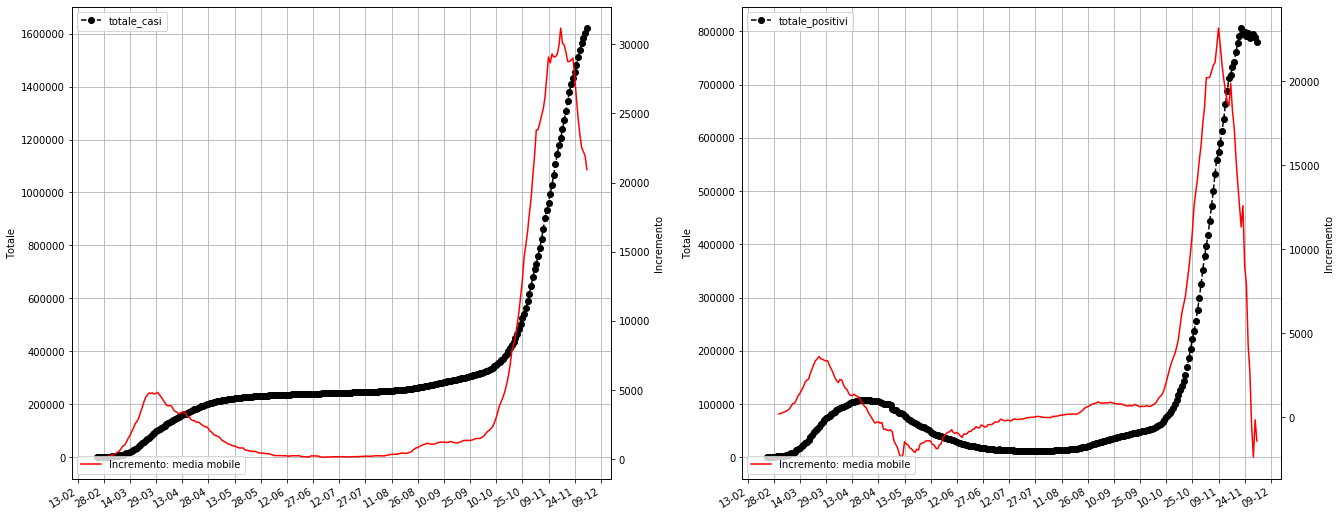

In [6]:
plot(ds1, 'totale_casi', 'totale_positivi')

## Ospedalizzati e terapia intensiva

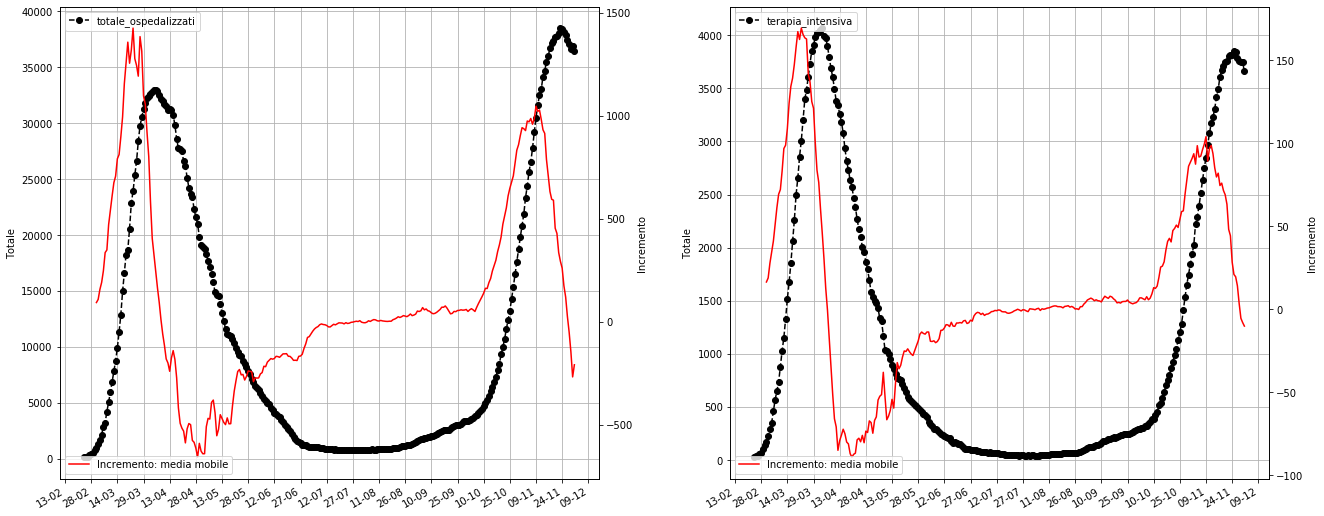

In [7]:
plot(ds1, 'totale_ospedalizzati', 'terapia_intensiva')

## Decessi

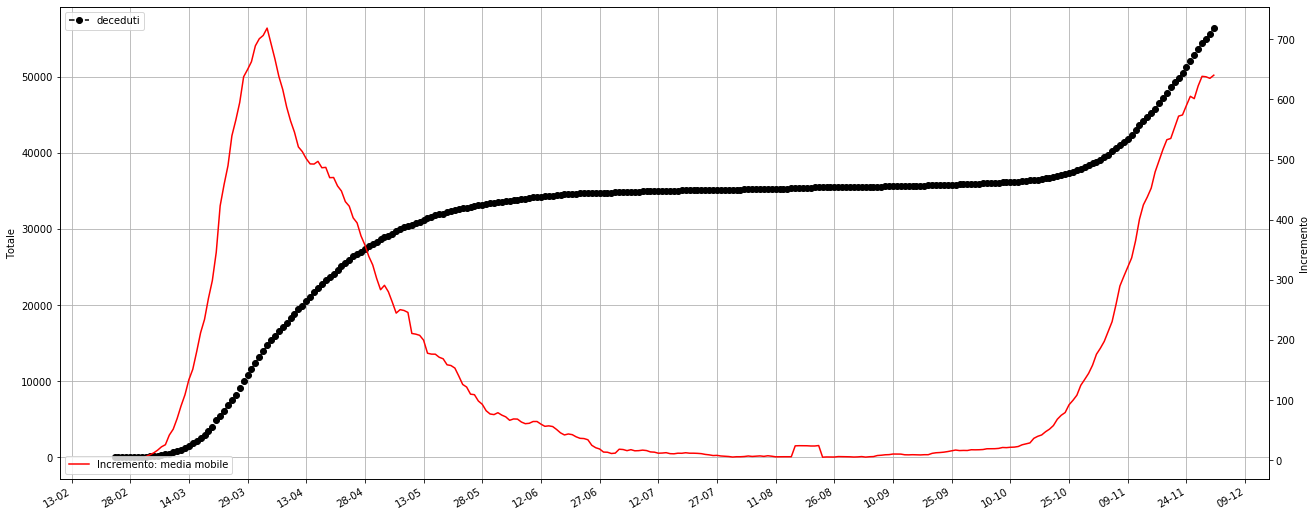

In [8]:
plot(ds1, 'deceduti', N=8)

## Indice Rt

size xs:  282
size I:  276
size DI:  269
size Rt:  269
size xs[Dt:]:  275


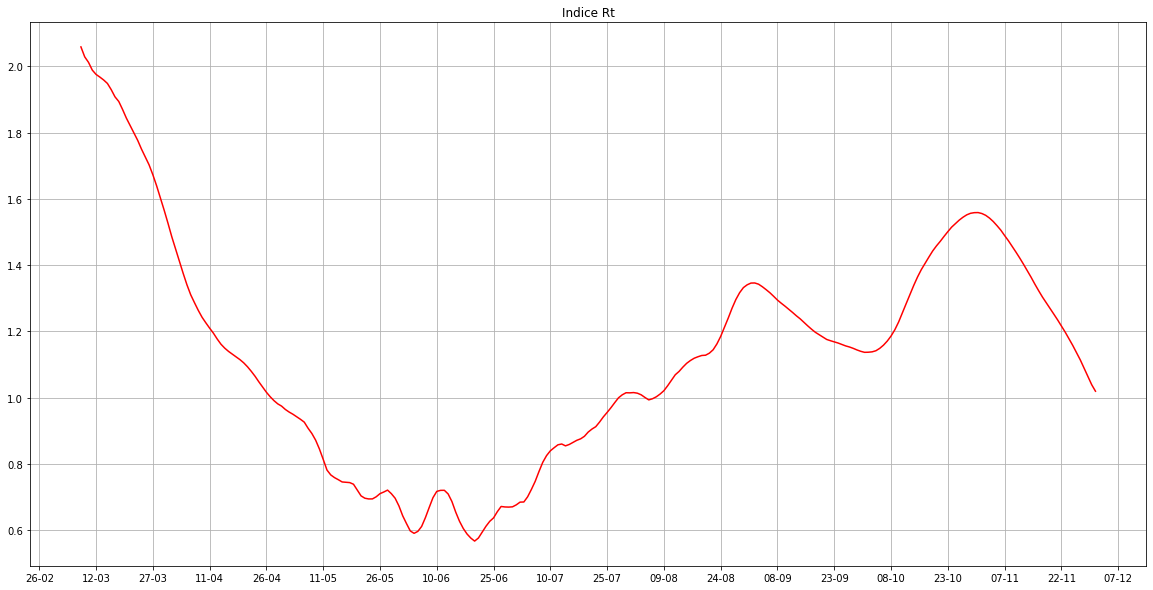

In [9]:
plotRt(ds1)

# Situazione Toscana ---------------------------

In [10]:
fileUrl = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
ds2 = pd.read_csv(fileUrl, parse_dates=['data'])
regione = "Toscana"

sds2 = ds2[ds2['denominazione_regione'] == regione].copy()

## Totale casi

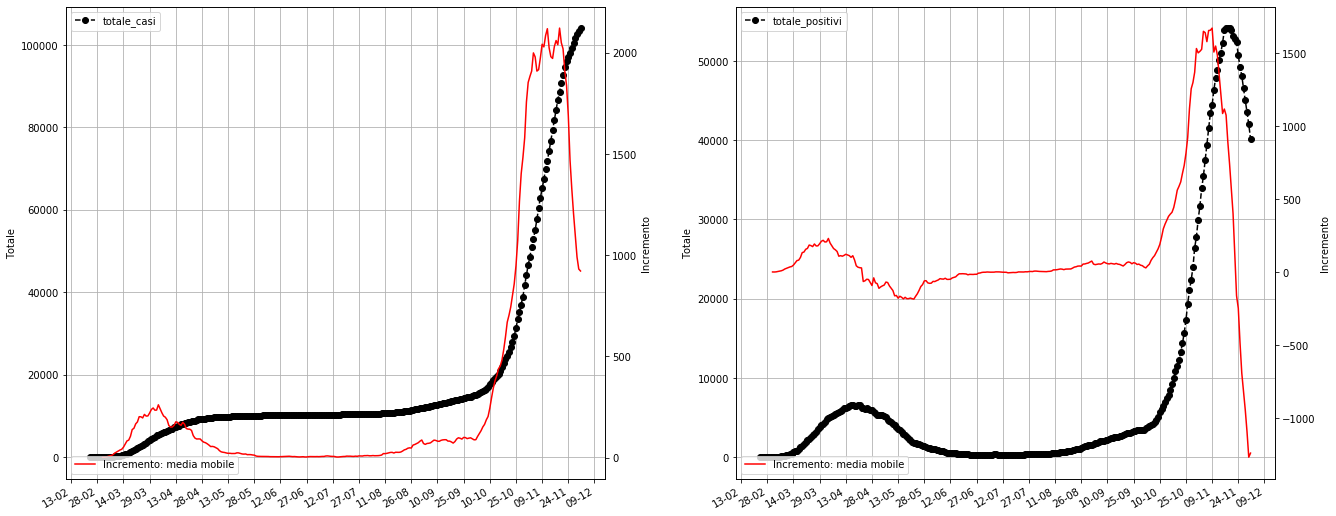

In [11]:
plot(sds2, 'totale_casi', 'totale_positivi')

## Ospedalizzati e terapia intensiva

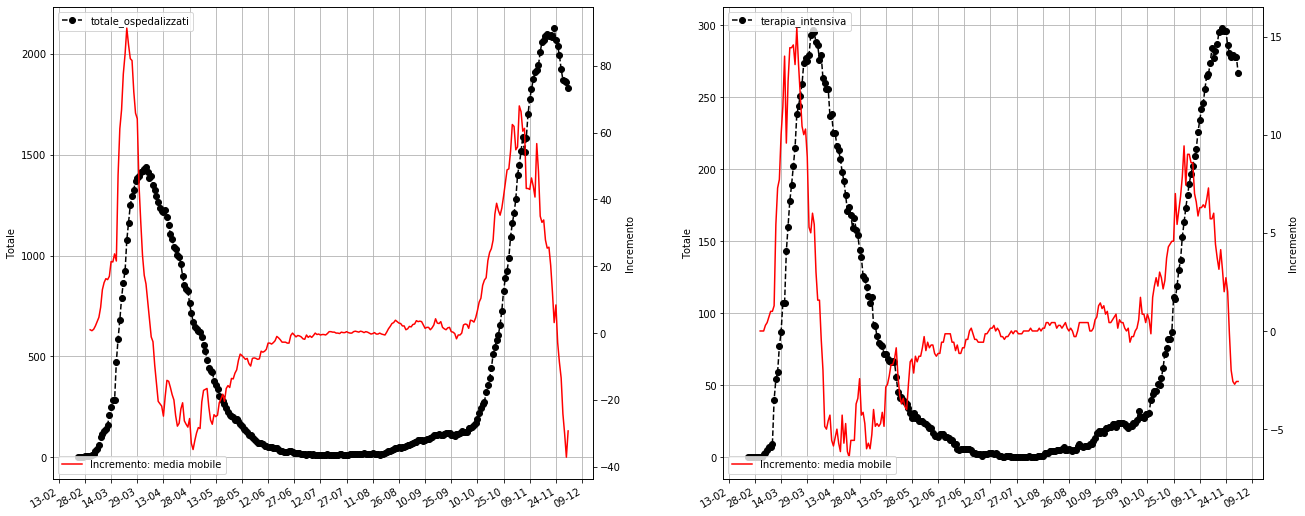

In [12]:
plot(sds2, 'totale_ospedalizzati', 'terapia_intensiva')

## Decessi

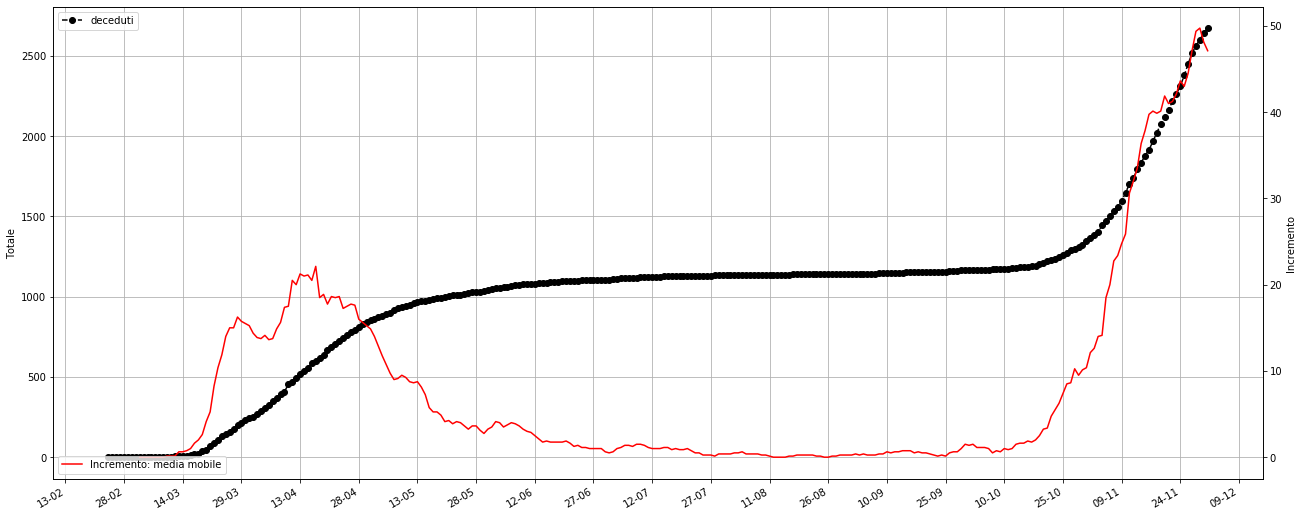

In [13]:
plot(sds2, 'deceduti', N=8)

## Indice Rt

size xs:  282
size I:  276
size DI:  269
size Rt:  269
size xs[Dt:]:  275


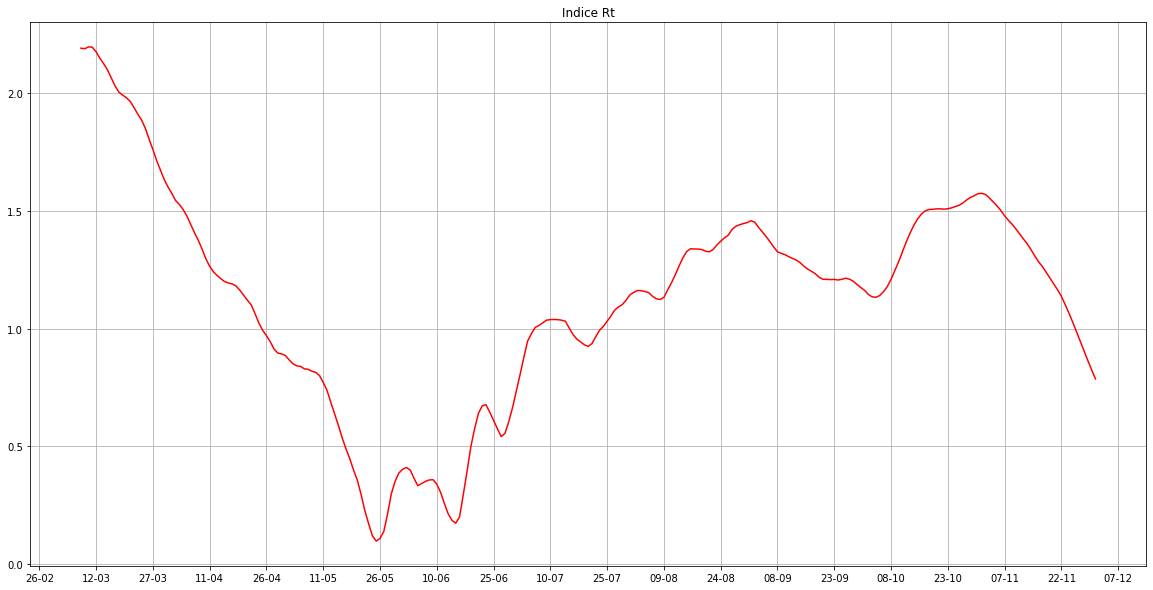

In [14]:
plotRt(sds2)

## Incremento vs Totale casi

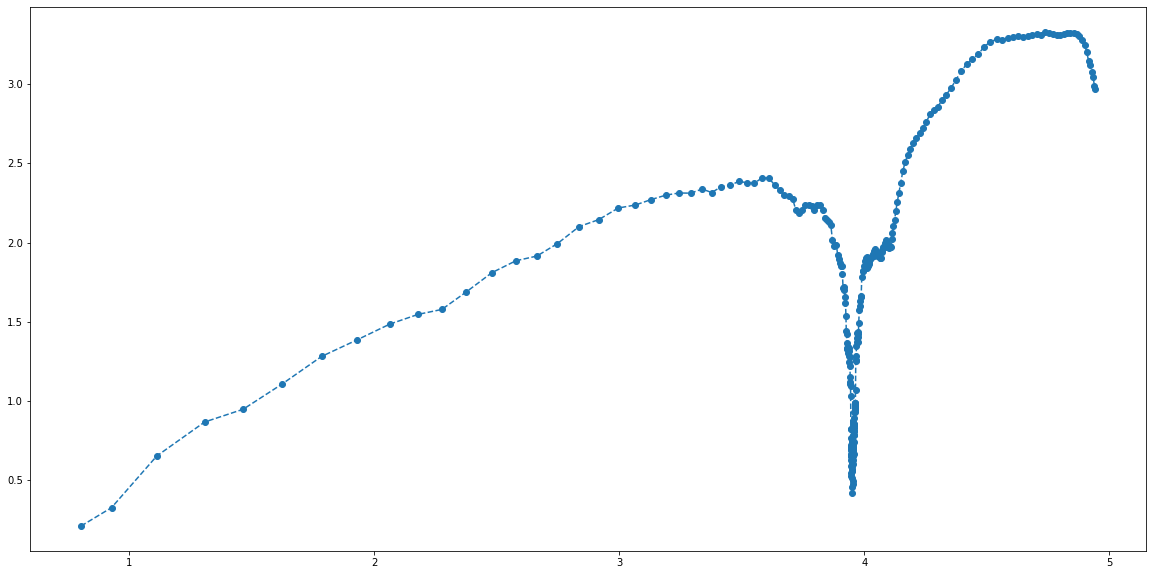

In [15]:
plotLogPhaseSpace(sds2, 'totale_casi', N=8)

# Pisa

In [16]:
fileUrl = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv"
ds3 = pd.read_csv(fileUrl, parse_dates=['data'])
provincia = "Pisa"
sds3 = ds3[ds3['denominazione_provincia'] == provincia].copy()

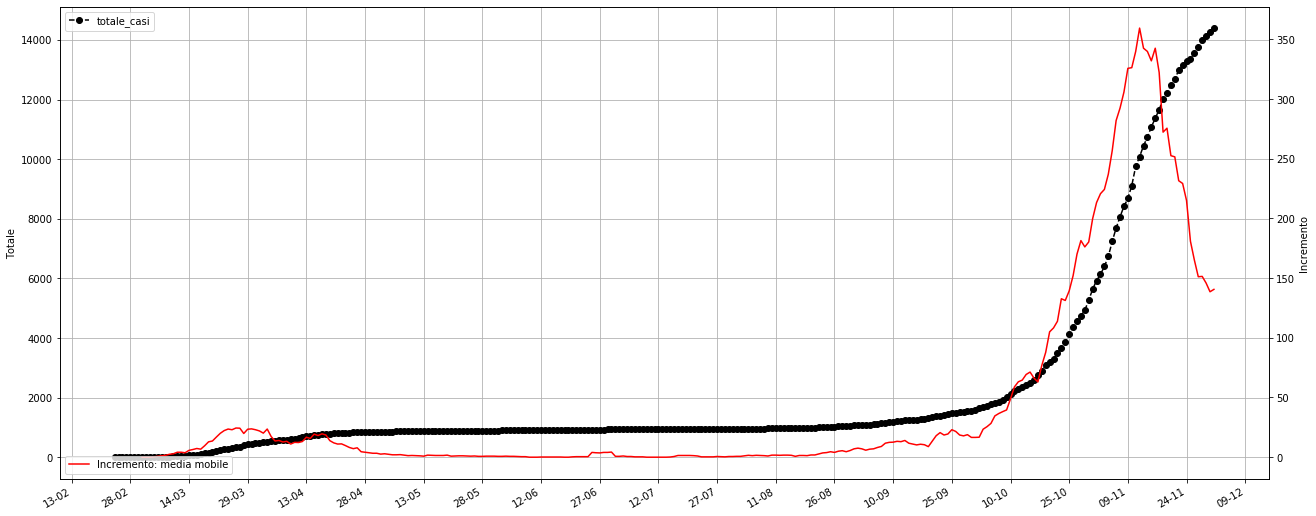

In [17]:
plot(sds3, 'totale_casi')

## Lucca

In [18]:
provincia = "Lucca"
sds4 = ds3[ds3['denominazione_provincia'] == provincia].copy()

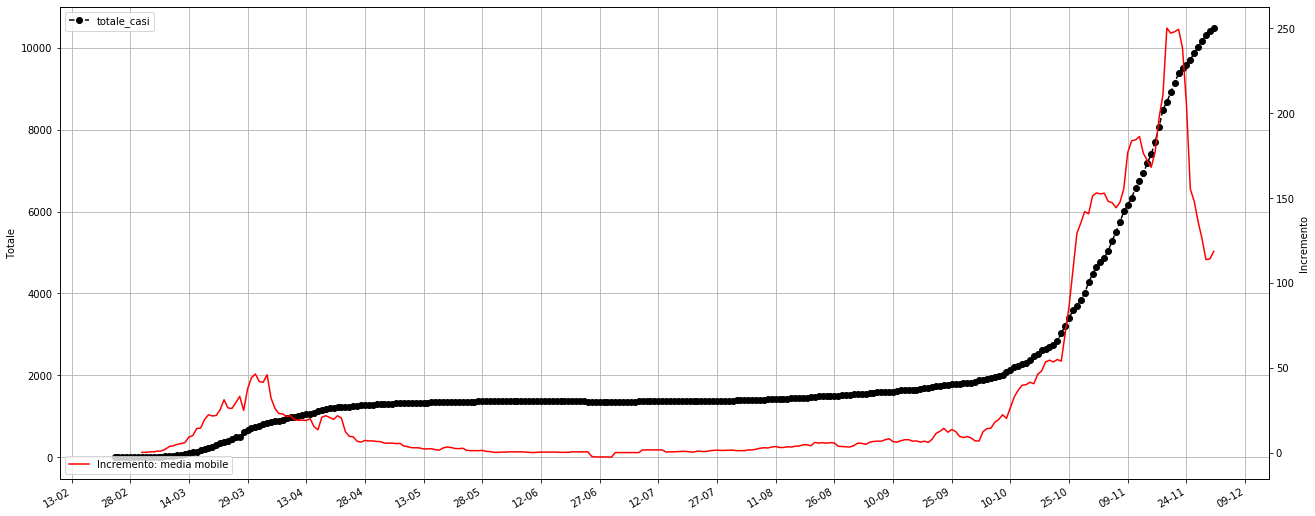

In [19]:
plot(sds4, 'totale_casi')